<a href="https://colab.research.google.com/github/alibekk93/IDP_analysis/blob/RAPID/getting_proteomes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting UniProt proteomes for Tempura species

## Setup

In [1]:
!pip install BIO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.4/279.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.4 MB/s eta 0:00:00


In [4]:
!pip install toytree toyplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.1/269.1 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.6 MB/s eta 0:00:00
  Created wheel for toyplot: filename=toyplot-1.0.3-py3-none-any.whl size=284023 sha256=c638ee66742da242b3b41a30a7a59a5ad8c664b1c34b5aa80f16b1e17e20d256
  Stored in directory: /root/.cache/pip/wheels/16/32/7f/813b2bd8d8580e4e8f6d56bf1d91df2737dd79dcaa64b17f41
Successfully built toyplot


In [2]:
import pandas as pd
import numpy as np

from Bio import SeqIO

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
### Read fasta ###

def read_fasta(fasta_file: str) -> pd.DataFrame:
  """Processes raw .fasta files

  Opens a .fasta file, parses the sequences and their IDs into a
  dataframe and returns the dataframe.

  Parameters
  ----------
  fasta_file : str
    the raw .fasta file directory.

  Returns
  -------
  pd.DataFrame
    a dataframe with ID, Sequence and Length columns.

  """

  # open the file
  handle = open(fasta_file, 'r')
  seq_list = list(SeqIO.parse(handle, 'fasta'))
  handle.close()

  # parse data into lists
  ids = [seq_record.id.split('|')[1] for seq_record in seq_list]
  seqs = [str(seq_record.seq) for seq_record in seq_list]
  lens = [len(seq) for seq in seqs]

  # save data into a dataframe
  df = pd.DataFrame({'ID':ids, 'Sequence':seqs, 'Length':lens})

  return df

Loading Tempura dataset

In [6]:
# tempura = pd.read_csv('/content/200617_TEMPURA.csv')
# tempura = pd.read_csv('/content/tempura_bacteria_uniprot.csv', index_col=0)
tempura = pd.read_csv('/content/tempura_filtered.csv', index_col=0)

Only keeping bacteria with available assembly or accession numbers

In [ ]:
# tempura = tempura[tempura['superkingdom']=='Bacteria']
# tempura.dropna(subset='assembly_or_accession', inplace=True)
# tempura.reset_index(drop=True, inplace=True)

Loading all_proteins

In [71]:
# all_proteins = pd.read_csv('/content/all_proteins.csv', index_col=0)
# all_proteins_filtered = pd.read_csv('/content/all_proteins_filtered.csv', index_col=0)
all_proteins_rapid = pd.read_csv('/content/all_proteins_rapid.csv', index_col=0)
all_proteins_disordered = pd.read_csv('/content/all_proteins_disordered.csv', index_col=0)
interesting_clusters = pd.read_csv('/content/interesting_clusters.csv', index_col=0)

Loading RAPID_disorder values

In [ ]:
# rapid_disorder_values = pd.read_csv('RAPID_disorder_values.csv', index_col=0)

## Getting UniProt IDs

Tepura has NCBI taxonomy IDs, but we need UniProt proteome IDs. We can get them using UniProt REST API search

In [ ]:
uniprot_jsons = []
failures = []

# loop through the taxonomy IDs and retrieve proteome data
for tax_id in tqdm(tempura['taxonomy_id']):
  # define the UniProt API URL
  url = f'https://rest.uniprot.org/proteomes/stream?format=json&query=%28%28taxonomy_id%3A{tax_id}%29%29'
  # send an HTTP GET request to the UniProt API
  response = requests.get(url)
  # Check if the request was successful
  if response.status_code == 200:
    # save JSON
    uniprot_jsons.append(response.json())
  else:
    failures.append(tax_id)
    uniprot_jsons.append({})

100%|██████████| 893/893 [08:24<00:00,  1.77it/s]


In many cases we get mre than one search result for one taxonomy ID. We need to check each search result and only keep the UniProt ID that has the same taxonomy ID as Tempura

In [ ]:
# initiate empty list to save UniProt IDs
uniprot_ids = []

# iterate through JSON results
for i, jsn in enumerate(uniprot_jsons):
  # get results
  results = jsn['results']
  # get candidate UniProt IDs and corresponding taxonomy IDs
  u_ids = [r['id'] for r in results]
  t_ids = [r['taxonomy']['taxonId'] for r in results]
  # make a dictionary of candidate IDs
  results_dict = {k:v for k, v in zip(t_ids, u_ids)}
  # get actual taxonomy ID
  taxonomy_id = tempura.loc[i, 'taxonomy_id']
  # save correct UniProt ID
  try:
    uniprot_ids.append(results_dict[taxonomy_id])
  except:
    # no correct ID found
    uniprot_ids.append(None)

We can now drop any Tempura rows with no available UniProt IDs and store the result

In [ ]:
tempura['uniprot_id'] = uniprot_ids

In [ ]:
tempura.dropna(subset='uniprot_id', inplace=True)

In [ ]:
tempura.reset_index(drop=True, inplace=True)

In [ ]:
tempura.to_csv('tempura_bacteria_uniprot.csv')

## Downloading UniProt proteomes

In [ ]:
!mkdir proteomes

In [ ]:
tempura.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   genus_and_species      680 non-null    object 
 1   taxonomy_id            680 non-null    int64  
 2   strain                 680 non-null    object 
 3   superkingdom           680 non-null    object 
 4   phylum                 680 non-null    object 
 5   class                  678 non-null    object 
 6   order                  673 non-null    object 
 7   family                 662 non-null    object 
 8   genus                  675 non-null    object 
 9   assembly_or_accession  680 non-null    object 
 10  Genome_GC              651 non-null    float64
 11  Genome_size            680 non-null    float64
 12  16S_accssion           680 non-null    object 
 13  16S_GC                 680 non-null    float64
 14  Tmin                   680 non-null    float64
 15  Topt_a

In [ ]:
failures = []

for i in tqdm(tempura.index):
  # make file path and get UniProt ID
  species = tempura.loc[i, 'genus_and_species'].replace(' ', '_')
  fasta_file_path = f'/content/proteomes/{species}.fasta'
  id = tempura.loc[i, 'uniprot_id']
  # define the UniProt API URL to retrieve FASTA data
  url = f'https://rest.uniprot.org/uniprotkb/stream?format=fasta&query=%28%28proteome%3A{id}%29%29'
  # send an HTTP GET request to the UniProt API to get FASTA data
  response = requests.get(url)
  # check if the request was successful
  if response.status_code == 200:
    # save the FASTA data to a file
    with open(fasta_file_path, 'w') as fasta_file:
      fasta_file.write(response.text)
  else:
    failures.append(id)

100%|██████████| 680/680 [56:33<00:00,  4.99s/it]


In [ ]:
failures

[]

In [ ]:
!zip -r /content/proteomes.zip /content/proteomes -i '*.fasta'
from google.colab import files
files.download('/content/proteomes.zip')

## Creating a DataFrame with all sequences

In [ ]:
all_proteins = pd.DataFrame(columns=['ID', 'Sequence', 'Length', 'Species'])

In [ ]:
for species in tqdm(tempura['genus_and_species']):
  filename = species.replace(' ', '_') + '.fasta'
  df = read_fasta(f'/content/proteomes/{filename}')
  df['Species'] = species
  all_proteins = pd.concat([all_proteins, df], ignore_index=True)

100%|██████████| 680/680 [01:02<00:00, 10.87it/s]


In [ ]:
all_proteins.to_csv('all_proteins.csv')

Filtering to only keep species with at least 1000 proteins

In [ ]:
# group the DataFrame by the 'species' column and count the number of records for each species
species_counts = all_proteins['Species'].value_counts()
# filter the species with more than 1000 records
selected_species = species_counts[species_counts >= 1000].index
# create a new DataFrame that only includes the selected species
all_proteins_filtered = all_proteins[all_proteins['Species'].isin(selected_species)].reset_index(drop=True)

Remove species that don't have 1000 records from Tempura

In [ ]:
tempura = tempura[tempura['genus_and_species'].isin(selected_species)].reset_index(drop=True)

In [ ]:
tempura.to_csv('tempura_filtered.csv')

Saving combined FASTA files for disorder calculations

In [ ]:
!mkdir /content/combined_fastas

In [ ]:
# define the maximum sequences per file
max_sequences_per_file = 75000

# split the DataFrame into chunks of max_sequences_per_file and save as FASTA files
for i, chunk in enumerate(range(0, len(all_proteins_filtered), max_sequences_per_file)):
  chunk_df = all_proteins_filtered.iloc[chunk:chunk + max_sequences_per_file]
  # create a FASTA file for the chunk
  fasta_file_path = f'/content/combined_fastas/output_{i+1}.fasta'
  with open(fasta_file_path, 'w') as fasta_file:
    for _, row in chunk_df.iterrows():
      id = row['ID']
      seq = row['Sequence']
      fasta_file.write(f'>{id}\n{seq}\n')

In [ ]:
!zip -r /content/combined_fastas.zip /content/combined_fastas -i '*.fasta'
from google.colab import files
files.download('/content/combined_fastas.zip')

  adding: content/combined_fastas/output_9.fasta (deflated 43%)
  adding: content/combined_fastas/output_12.fasta (deflated 43%)
  adding: content/combined_fastas/output_10.fasta (deflated 43%)
  adding: content/combined_fastas/output_4.fasta (deflated 43%)
  adding: content/combined_fastas/output_2.fasta (deflated 43%)
  adding: content/combined_fastas/output_5.fasta (deflated 43%)
  adding: content/combined_fastas/output_3.fasta (deflated 43%)
  adding: content/combined_fastas/output_8.fasta (deflated 43%)
  adding: content/combined_fastas/output_1.fasta (deflated 43%)
  adding: content/combined_fastas/output_6.fasta (deflated 43%)
  adding: content/combined_fastas/output_16.fasta (deflated 43%)
  adding: content/combined_fastas/output_7.fasta (deflated 43%)
  adding: content/combined_fastas/output_13.fasta (deflated 43%)
  adding: content/combined_fastas/output_17.fasta (deflated 43%)
  adding: content/combined_fastas/output_11.fasta (deflated 43%)
  adding: content/combined_fastas/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Combining partial RAPID results and loading into all_proteins

In [ ]:
rapid_disorder_values = pd.DataFrame(columns = ['Prot. ID', 'Disorder Content %'])

In [ ]:
# set number of csv files with partial RAPID calculation results
n = 17
# iterate through each file and concatenate to all_proteins_filtered
for i in tqdm(range(n)):
  # make filename with addition of '0' if 1-9
  if i+1 < 10:
    filename = f'0{i+1}.csv'
  else:
    filename = f'{i+1}.csv'
  # read csv with RAPID result
  rapid_result = pd.read_csv(filename)
  rapid_result = rapid_result[['Prot. ID', 'Disorder Content %']]
  # append RAPID disorder prediciton to overall dataframe
  rapid_disorder_values = pd.concat([rapid_disorder_values, rapid_result], axis=0)

  0%|          | 0/17 [00:00<?, ?it/s]


FileNotFoundError: ignored

In [ ]:
rapid_disorder_values.to_csv('RAPID_disorder_values.csv')

Appending RAPID disorder values to all_proteins_filtered

In [ ]:
rapid_disorder_values

In [ ]:
all_proteins_rapid = all_proteins_filtered.join(rapid_disorder_values.set_index('Prot. ID'),
                                                   on='ID', how='inner')

In [ ]:
all_proteins_rapid['RAPID_disorder'] = all_proteins_rapid['Disorder Content %'] / 100
all_proteins_rapid.drop('Disorder Content %', axis=1, inplace=True)

# all_proteins_rapid['RAPID_fully_disordered'] = all_proteins_rapid['RAPID_disorder'] >= 0.5
# all_proteins_rapid['RAPID_n_disordered_residues'] = all_proteins_rapid['RAPID_disorder'] * all_proteins_rapid['Length']

In [ ]:
all_proteins_rapid.to_csv('all_proteins_rapid.csv')

## FCR / NCPR filtering

In [ ]:
def compute_fcr(row):
    aa_seq = row['Sequence']
    n = len(aa_seq)
    f_plus = sum(aa_seq.count(char) for char in ['R', 'K', 'H']) / n # Histidine?
    f_minus = sum(aa_seq.count(char) for char in ['D', 'E']) / n
    ncpr = abs(f_plus - f_minus)
    fcr = (f_plus + f_minus)
    return pd.Series([f_plus, f_minus, ncpr, fcr])

In [ ]:
all_proteins_rapid[['f_plus', 'f_minus', 'ncpr', 'fcr']] = all_proteins_rapid.apply(compute_fcr, axis=1)

In [ ]:
all_proteins_rapid['idp_type'] = None

In [ ]:
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] < 0.25) & (all_proteins_rapid['ncpr'] < 0.25), 'idp_type'] = 1
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] >= 0.25) & (all_proteins_rapid['fcr'] <= 0.35) &\
                      (all_proteins_rapid['ncpr'] <= 0.35), 'idp_type'] = 2
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] > 0.35) & (all_proteins_rapid['ncpr'] <= 0.35), 'idp_type'] = 3
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] > 0.35) & (all_proteins_rapid['ncpr'] > 0.35) &\
                      (all_proteins_rapid['f_minus'] > 0.35), 'idp_type'] = 4
all_proteins_rapid.loc[(all_proteins_rapid['fcr'] > 0.35) & (all_proteins_rapid['ncpr'] > 0.35) &\
                      (all_proteins_rapid['f_plus'] > 0.35), 'idp_type'] = 5

Filter out "disordered" proteins - these are either:
1. IDP type 3, 4 or 5
2. RAPID_disorder >= 0.5
3. Have at least 100 disordered residues as predicted by RAPID

The last point is to include longer proteins that just have a section of IDR. RAPID does not provide disorder at residue level, so it's as good as we can get to having a filter for 30 consecutive disordered residues

In [ ]:
disordered_filter = (all_proteins_rapid['idp_type'] > 2) | \
                    (all_proteins_rapid['RAPID_disorder'] >= 0.5) | \
                    (all_proteins_rapid['RAPID_disorder'] * all_proteins_rapid['Length'] >= 100)
all_proteins_rapid['disordered'] = disordered_filter
all_proteins_disordered = all_proteins_rapid[disordered_filter]

In [ ]:
# all_proteins_disordered.to_csv('all_proteins_disordered.csv')

In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))

# sns.scatterplot(data=all_proteins_rapid, x='f_plus', y='f_minus',
#                 hue='idp_type', palette='colorblind')

# ax.set_xlim(0, 0.75)
# ax.set_ylim(0, 0.75)

# fig.show()

In [ ]:
# all_proteins_disordered.groupby('idp_type').mean()

## EDA for Overall IDP abundance ~ optimal temerature relationship

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 8))

# sns.kdeplot(data=all_proteins_rapid[all_proteins_rapid['RAPID_fully_disordered']],
#                 x='Length', y='RAPID_disorder', alpha=0.5, fill=True, ax=ax)
# ax.set_xlim(0, 500)
# fig.show()

In [ ]:
tempura = pd.read_csv('/content/tempura_filtered.csv', index_col=0)

In [ ]:
species_rapid_disorder = all_proteins_rapid.groupby('Species').mean()[['RAPID_disorder']]
tempura = tempura.join(species_rapid_disorder, how='inner', on='genus_and_species')

species_rapid_idp_count = all_proteins_disordered.groupby('Species').count()[['RAPID_disorder']]
species_rapid_idp_count.columns = ['IDP_count']
tempura = tempura.join(species_rapid_idp_count, how='inner', on='genus_and_species')

species_rapid_protein_count = all_proteins_rapid.groupby('Species').count()[['RAPID_disorder']]
species_rapid_protein_count.columns = ['protein_count']
tempura = tempura.join(species_rapid_protein_count, how='inner', on='genus_and_species')
tempura['IDP_percentage'] = tempura['IDP_count'] / tempura['protein_count']

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(data=tempura, x='Topt_ave', y='RAPID_disorder', ax=ax)

fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(data=tempura, x='Topt_ave', y='IDP_count', ax=ax)

fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(data=tempura, x='Topt_ave', y='IDP_percentage', ax=ax)

fig.show()

## Clustering all proteins using CD-HIT

In [ ]:
# # saving all proteins to a single fasta file
# with open('/content/all_proteins.fasta', 'w') as fasta_file:
#   for _, row in all_proteins_rapid.iterrows():
#     id = row['ID']
#     seq = row['Sequence']
#     fasta_file.write(f'>{id}\n{seq}\n')

CH-HIT ran on local system using command:
```
cd-hit -i all_proteins.fasta -o all_proteins_70 -c 0.7
```

In [ ]:
# importing CD-HIT results

In [ ]:
clustered_proteins_file = '/content/all_proteins_70.clstr'

all_proteins_rapid['cluster'] = '0'
clusters = {}

# Read the clustered proteins file and store clusters
with open(clustered_proteins_file ,'r') as f:
  for line in f:
    if line.startswith('>Cluster'):
      cluster_id = line.strip().split()[1]
      clusters[cluster_id] = []
    else:
      protein_id = line.strip().split('>')[1].split('...')[0]
      clusters[cluster_id].append(protein_id)

In [ ]:
protein_cluster_mapping = {cid: proteins for cid, proteins in clusters.items()}
# Reverse cluster dictionary to have ID:cluster
protein_cluster_mapping = {protein_id: cluster for cluster, proteins in protein_cluster_mapping.items() for protein_id in proteins}
# Map clusters to df
all_proteins_rapid['cluster'] = all_proteins_rapid['ID'].map(protein_cluster_mapping)

We will filter to find clusters that:

1. Have at least 10 proteins
2. Have at least 1 disordered protein
2. Have at least 1 non-disordered protein

We will call these clusters `interesting_clusters` because they are, well, interesting

We will store clusters with only disordered proteins as `disordered_clusters`

In [ ]:
cluster_groups = all_proteins_rapid.groupby('cluster').agg({'disordered':['max', 'min'], 'ID':'count'})

In [ ]:
min_cluster_size = 10

only_disordered = cluster_groups[(cluster_groups['disordered']['min']) & (cluster_groups['ID']['count']>=min_cluster_size)].index
mixed_clusters = cluster_groups[(cluster_groups['disordered']['max']) & (~cluster_groups['disordered']['min']) & \
                                (cluster_groups['ID']['count']>=min_cluster_size)].index

In [ ]:
len(only_disordered)

95

In [ ]:
interesting_clusters = all_proteins_rapid[all_proteins_rapid['cluster'].isin(mixed_clusters)]

In [ ]:
# interesting_clusters.to_csv('interesting_clusters.csv')

In [ ]:
disordered_clusters = all_proteins_rapid[all_proteins_rapid['cluster'].isin(only_disordered)]
# disordered_clusters.to_csv('disordered_clusters.csv')

## Cluster vizualisations

In [ ]:
interesting_clusters.groupby('cluster').std()['RAPID_disorder'].sort_values(ascending=False)[:10]

<ipython-input-50-c9c9ae405284>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  interesting_clusters.groupby('cluster').std()['RAPID_disorder'].sort_values(ascending=False)[:10]


cluster
207030    0.318319
46504     0.294450
900878    0.263818
133217    0.254680
316086    0.253645
147816    0.250248
426708    0.232290
162959    0.223509
849025    0.219221
784912    0.217289
Name: RAPID_disorder, dtype: float64

In [ ]:
def plot_cluster(cluster):
  cluster_df = all_proteins_rapid[all_proteins_rapid['cluster']==cluster].sort_values('RAPID_disorder')

  cluster_df_topt = cluster_df.join(tempura[['genus_and_species', 'Topt_ave']].set_index('genus_and_species'), on='Species')

  sns.scatterplot(data=cluster_df_topt, x='Topt_ave', y='RAPID_disorder')
  plt.show()

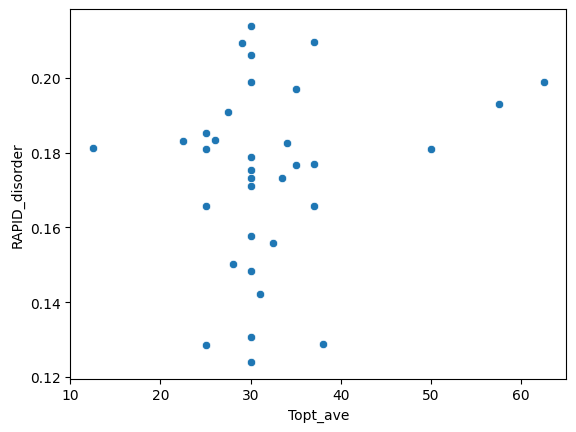

In [ ]:
plot_cluster('125601')

In [ ]:
all_proteins_rapid[all_proteins_rapid['cluster']=='125601']

,ID,Sequence,Length,Species,RAPID_disorder,f_plus,f_minus,ncpr,fcr,idp_type,disordered,cluster
21824,A0A0D8BQM5,MGSIIISALLALVIGAVVGFFVRKSIAEAKIGGAKAAAKQLIEEAK...,518,Geobacillus kaustophilus,0.1988,0.191120,0.193050,0.001931,0.384170,3,True,125601
31098,M5QPR2,MGETIISALLALVVGAVVGFFVRKSIAEAKIGGAQAAAKQMIEEAK...,518,Anoxybacillus gonensis,0.1931,0.193050,0.200772,0.007722,0.393822,3,True,125601
51458,A0A1U9K9S0,MIGSLGEILILLATAAVSAGIGYFVRKRLAEAKISSAEEAAERIID...,514,Novibacillus thermophilus,0.1809,0.188716,0.198444,0.009728,0.387160,3,True,125601
54640,A0A1D7QVT1,MDLIYQILALLLVAVIGILIGYFIRKSLAEAKISSAEALAKQTVEE...,520,Bacillus beveridgei,0.2096,0.188462,0.201923,0.013462,0.390385,3,True,125601
91887,A0A0B5ALP4,MGAFEITFILAGIIVGVVVGYLIHKFMMDAKVGGAKGTVEQILANG...,519,Jeotgalibacillus malaysiensis,0.1657,0.184971,0.192678,0.007707,0.377649,3,True,125601
99667,A0A3E0WKA5,MDSLMLISILLVILIVGIVVGYLIRKSIAEAKISSAETLAKQIVDE...,520,Virgibacillus dokdonensis,0.1769,0.180769,0.196154,0.015385,0.376923,3,True,125601
124667,A0A3S8RXC5,MHDGVWVALVAAALFFGFVIGYFIRKSLAEAKISSAEHAASQILES...,513,Paenibacillus lentus,0.1287,0.185185,0.189084,0.003899,0.374269,3,True,125601
128854,A0A1W5ZVT3,MDLISSLIFILLALIVGSVVGYLIRKSIAEAKISSAEELAKQIVEE...,520,Halobacillus mangrovi,0.1827,0.173077,0.196154,0.023077,0.369231,3,True,125601
168788,A0A0U4F4D2,MDNPLIISILLAVILIVGIVVGYLIRKSIGEAKITSAENLAKQIVD...,521,Lentibacillus amyloliquefaciens,0.1766,0.166987,0.195777,0.028791,0.362764,3,True,125601
204166,A0A223D2A0,MDSLLPILLSVIFLAVGLVGGYLVRRNIAEGKLAAAELRAEQILDT...,513,Tumebacillus algifaecis,0.1988,0.189084,0.189084,0.000000,0.378168,3,True,125601


In [ ]:
disordered_clusters

,ID,Sequence,Length,Species,RAPID_disorder,f_plus,f_minus,ncpr,fcr,idp_type,disordered,cluster
425,A0A172T533,MKRTYQPSRIKRKRTHGFLARKSTPGGRRVLKNRRRTGRWRLTV,44,Fervidobacterium pennivorans,1.0000,0.409091,0.000000,0.409091,0.409091,5,True,941189
3714,A0A3T0D4R5,MEQKRGMRKTRIGVVVSDKMDKTVVVAVETLVQHPLYKKTIKRTTK...,86,Caldicellulosiruptor changbaiensis,0.3140,0.279070,0.127907,0.151163,0.406977,3,True,841942
3765,A0A3T0D579,MLTKEQKQEIIKKYQLHESDTGSPEVQIALLTERINRLNEHLQIHK...,88,Caldicellulosiruptor changbaiensis,0.3295,0.272727,0.136364,0.136364,0.409091,3,True,877979
3823,A0A3T0D5T9,MSEVRVGENESLDSALRRFKKKCAEAGVLAELRKREHYESPSVRRK...,58,Caldicellulosiruptor changbaiensis,0.8793,0.362069,0.155172,0.206897,0.517241,3,True,929392
4641,A0A3T0D4Q4,MKVRPSVKPICEKCKVIRRKGKIRIICENPKHKQRQG,37,Caldicellulosiruptor changbaiensis,0.7027,0.378378,0.054054,0.324324,0.432432,3,True,941621
...,...,...,...,...,...,...,...,...,...,...,...,...
1166761,A0A1J1E678,MKTRASIKKRSEECKIVKRKGRLYVINKKNPRFKQRQG,38,Ichthyobacterium seriolicida,1.0000,0.394737,0.052632,0.342105,0.447368,3,True,946903
1167320,A0A1B1BMY6,MARLAGVDIPRDKRVEVALTYIFGVGRTRALKTLADVEIDGNIRVK...,124,Cryobacterium arcticum,0.2661,0.258065,0.137097,0.120968,0.395161,3,True,809653
1167328,A0A1B1BQ85,MAKAQDVRPIIKLRSTAGTGYTYVTKKNRRNNPDRLVLKKYDPVVR...,55,Cryobacterium arcticum,0.4364,0.290909,0.109091,0.181818,0.400000,3,True,936233
1167451,A0A317ZQ86,MAKTDETVVPAEALVRGYRKTLRGYVTSDKMDKTIVVEVEDRVKHP...,97,Cryobacterium arcticum,0.2165,0.226804,0.144330,0.082474,0.371134,3,True,801625


Saving all proteins from `interesting_clusters` as `fasta` to predict their disorder using **fIDPnn**


In [ ]:
interesting_clusters = interesting_clusters[interesting_clusters['Length'] >= 20]

In [ ]:
!mkdir /content/clustered_fastas/

In [ ]:
# define the maximum sequences per file
max_sequences_per_file = 500

# split the DataFrame into chunks of max_sequences_per_file and save as FASTA files
for i, chunk in enumerate(range(0, len(interesting_clusters), max_sequences_per_file)):
  chunk_df = interesting_clusters.iloc[chunk:chunk + max_sequences_per_file]
  # create a FASTA file for the chunk
  fasta_file_path = f'/content/clustered_fastas/clustered_proteins_{i+1}.fasta'
  with open(fasta_file_path, 'w') as fasta_file:
    for _, row in chunk_df.iterrows():
      id = row['ID']
      seq = row['Sequence']
      fasta_file.write(f'>{id}\n{seq}\n')

In [ ]:
!zip -r /content/clustered_fastas.zip /content/clustered_fastas -i '*.fasta'
from google.colab import files
files.download('/content/clustered_fastas.zip')

  adding: content/clustered_fastas/clustered_proteins_11.fasta (deflated 46%)
  adding: content/clustered_fastas/clustered_proteins_3.fasta (deflated 47%)
  adding: content/clustered_fastas/clustered_proteins_12.fasta (deflated 46%)
  adding: content/clustered_fastas/clustered_proteins_18.fasta (deflated 48%)
  adding: content/clustered_fastas/clustered_proteins_23.fasta (deflated 52%)
  adding: content/clustered_fastas/clustered_proteins_4.fasta (deflated 49%)
  adding: content/clustered_fastas/clustered_proteins_6.fasta (deflated 45%)
  adding: content/clustered_fastas/clustered_proteins_1.fasta (deflated 59%)
  adding: content/clustered_fastas/clustered_proteins_19.fasta (deflated 46%)
  adding: content/clustered_fastas/clustered_proteins_2.fasta (deflated 44%)
  adding: content/clustered_fastas/clustered_proteins_9.fasta (deflated 47%)
  adding: content/clustered_fastas/clustered_proteins_7.fasta (deflated 48%)
  adding: content/clustered_fastas/clustered_proteins_21.fasta (deflate

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Contrast study

In [11]:
from Bio import Entrez, SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

import toytree
import toyplot.svg
import toyplot

Download nt sequences for 16s genes of all species and save as `fasta` files

In [326]:
# # Set your email address
# Entrez.email = 'akrug104@uottawa.ca'

# # Get the list of accession numbers and species names
# accession_list = tempura['16S_accssion'].tolist()
# species_list = tempura['genus_and_species'].tolist()

# # Add outgroup
# accession_list.append('NG_046384.1')
# species_list.append('Pyrobaculum ferrireducens')

# # Fetch the sequences from NCBI
# handle = Entrez.efetch(db='nucleotide', id=accession_list, rettype='fasta', retmode='text')
# records = list(SeqIO.parse(handle, 'fasta'))

# # Filter the records to only allow sequences up to 5000 nt long
# records = [r for r in  records if len(r.seq) <= 5000]

# # Save the sequences to a single fasta file
# with open('16S_all.fasta', 'w') as output_handle:
#     SeqIO.write(records, output_handle, 'fasta')

A sequence from an archaea was added as outgroup (NG_046384.1 of *Pyrobaculum ferrireducens*)

Alignment of sequences was done externally using MAFFT with default parameters except for specification for nucleotide sequences

In [327]:
# # Read the fasta file
# records = SeqIO.parse('/content/16S_aligned.fasta', 'fasta')

# # Create a multiple sequence alignment object
# alignment = MultipleSeqAlignment(records)

# # Calculate the p-distance matrix
# calculator = DistanceCalculator('identity')
# distance_matrix = calculator.get_distance(alignment)

# with open('distance_matrix.txt', 'w') as f:
#   distance_matrix.format_phylip(f)

Tree has been constructed using UPGMA and saved in `Newick` format

In [329]:
# # Construct the tree
# constructor = DistanceTreeConstructor()
# tree = constructor.upgma(distance_matrix)
# # Reroot the tree
# tree.root_with_outgroup({'name':'NG_046384.1'})
# # Save the tree in Newick format
# Phylo.write(tree, 'tree.nwk', format='newick')

1

Reading the tree if it has been created before

In [330]:
# Load the tree from a file
tree = Phylo.read('tree.nwk', 'newick')

In [331]:
tree.root_with_outgroup({'name':'NG_046384.1'})

In [333]:
for t in tqdm(tree.get_terminals()):
  accession = t.name.split('.')[0]
  tempura_data = tempura[tempura['16S_accssion']==accession]
  t.OGT_contrast = 0
  t.FOD_contrast = 0
  t.is_leaf = True
  try:
    t.species = tempura_data['genus_and_species'].iloc[0]
    disorder_data = all_proteins_rapid[all_proteins_rapid['Species']==t.species]
    t.OGT = tempura_data['Topt_ave'].iloc[0]
    t.FOD = disorder_data['RAPID_disorder'].mean()
    if t.FOD == np.nan:
      print(t)
  except:
    t.species = 'OUTGROUP (Pyrobaculum ferrireducens)'
    t.OGT = 100
    t.FOD = 0.1184798938

100%|██████████| 311/311 [00:33<00:00,  9.16it/s]


In [345]:
for n in tqdm(tree.get_nonterminals()):
  n.species = n.name
  n.OGT = tempura['Topt_ave'].mean()
  n.FOD = all_proteins_rapid['RAPID_disorder'].mean()
  n.OGT_contrast = 0
  n.FOD_contrast = 0
  n.is_leaf = False

100%|██████████| 310/310 [00:00<00:00, 379.89it/s]


We will use LS minimization for quazi-independent contrasts to estimate OGT and MDS of internal nodes

In [346]:
def RSS_single(node, attribute, m=1):
  rss = 0.0
  distances = [c.branch_length for c in node.clades]
  for child, distance in zip(node.clades, distances):
    value_p = getattr(node, attribute)
    value_c = getattr(child, attribute)
    rss += ((value_p - value_c)**2) / distance**m
  return rss

def RSS_sum(nodes, attribute, m=1):
  return sum(RSS_single(node, attribute, m) for node in nodes)

def node_optimization(x0, nodes, attribute, m=1):
  # Assign values from the optimization parameters to internal nodes
  for i, node in enumerate(nodes):
    if not node.is_leaf:
      setattr(node, attribute, x0[i])

  # Calculate the total RSS for the tree
  total_rss = RSS_sum(nodes, attribute, m=m)

  return total_rss

In [347]:
nodes = [node for node in tree.get_nonterminals() + tree.get_terminals()][1:]

initial_guesses_OGT = [node.OGT for node in nodes]
initial_guesses_FOD = [node.FOD for node in nodes]

In [348]:
import scipy

In [349]:
node_optimization(initial_guesses_OGT, nodes, 'OGT', m=1)
OGT_result = scipy.optimize.minimize(node_optimization, initial_guesses_OGT, args=(nodes, 'OGT', 1))
print(f'RSS = {OGT_result.fun} with OGT:\n{OGT_result.x}')

In [350]:
node_optimization(initial_guesses_FOD, nodes, 'FOD', m=1)
FOD_result = scipy.optimize.minimize(node_optimization, initial_guesses_FOD, args=(nodes, 'FOD', 1))
print(f'RSS = {FOD_result.fun} with FOD:\n{FOD_result.x}')

In [351]:
def calc_contrast(child_values:list):
  total_difference = sum(child_values[j] - child_values[i] for i in range(len(child_values)) \
                         for j in range(i+1, len(child_values)))
  contrast = total_difference/(len(child_values)*(len(child_values) - 1)/2)
  return contrast

In [352]:
# contrast calculation
for node in nodes:
  if not node.is_leaf:
    node.OGT_contrast = calc_contrast([child.OGT for child in node.clades])
    node.FOD_contrast = calc_contrast([child.FOD for child in node.clades])

In [353]:
OGTvsFOD = pd.DataFrame({'FOD':[node.FOD for node in nodes if not node.is_leaf],
                         'OGT':[node.OGT for node in nodes if not node.is_leaf],
                         'FOD_contrast':[node.FOD_contrast for node in nodes if not node.is_leaf],
                         'OGT_contrast':[node.OGT_contrast for node in nodes if not node.is_leaf]},
                        index=[node.name for node in nodes if not node.is_leaf])

<Axes: xlabel='OGT_contrast', ylabel='FOD_contrast'>

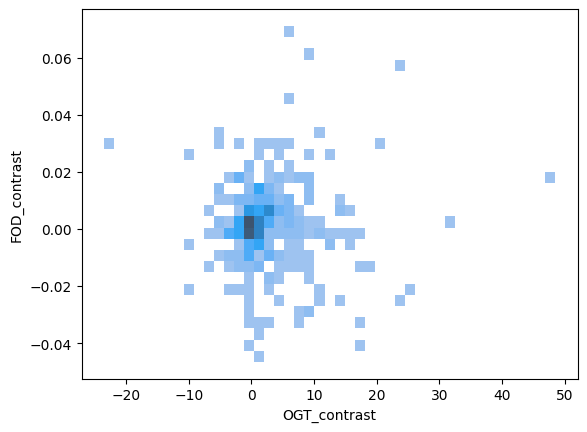

In [354]:
sns.histplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast')

<Axes: xlabel='OGT_contrast', ylabel='FOD_contrast'>

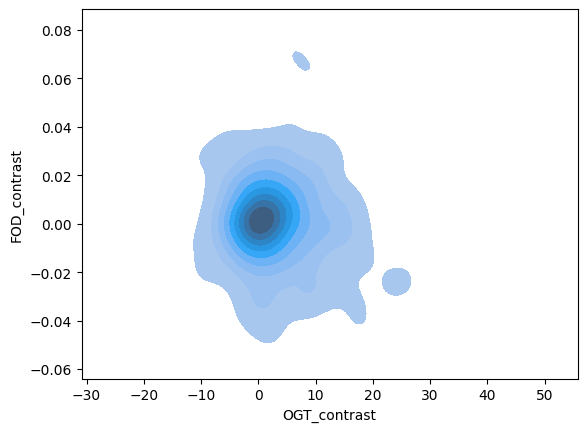

In [367]:
sns.kdeplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast', fill=True)

<Axes: xlabel='OGT_contrast', ylabel='FOD_contrast'>

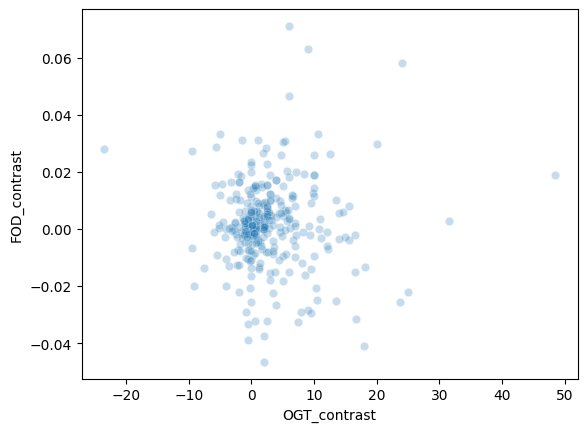

In [370]:
sns.scatterplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast', alpha=0.25)

In [428]:
OGTvsFOD_stats = scipy.stats.linregress(OGTvsFOD['OGT_contrast'], OGTvsFOD['FOD_contrast'])
OGTvsFOD_stats, OGTvsFOD_stats.rvalue**2

(LinregressResult(slope=-1.0671287189634963e-05, intercept=0.0016655250847412001, rvalue=-0.004512412360666884, pvalue=0.937032705730869, stderr=0.00013496912067150727, intercept_stderr=0.0009373177254303604),
 2.036186531269928e-05)

Seems like when phylogeny is controlled for, there is no relationship between OGT and FOD

In [ ]:
df = pd.DataFrame({'X':OGTvsFOD['OGT_contrast'],
                  'Y':OGTvsFOD['FOD_contrast']})

num_iterations = 10000
observed_corr, _ = scipy.stats.spearmanr(df['X'], df['Y'])

# Initialize an array to store resampled correlations
resampled_correlations = []

# Perform permutation testing (resampling)
for i in range(num_iterations):
    permuted_Y = np.random.permutation(df['Y'])  # Permute the Y values
    resampled_corr, _ = scipy.stats.spearmanr(df['X'], permuted_Y)
    resampled_correlations.append(resampled_corr)

# Calculate the p-value based on the resampled correlations
p_value = (np.abs(resampled_correlations) >= np.abs(observed_corr)).mean()
print("p-value:", p_value)

In [429]:
from statsmodels.api import OLS

In [435]:
X = OGTvsFOD['OGT_contrast']
y = OGTvsFOD['FOD_contrast']

linear_model = OLS(y, X).fit()

In [440]:
print(linear_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           FOD_contrast   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.002
Method:                 Least Squares   F-statistic:                             0.4751
Date:                Mon, 27 Nov 2023   Prob (F-statistic):                       0.491
Time:                        18:14:40   Log-Likelihood:                          856.76
No. Observations:                 309   AIC:                                     -1712.
Df Residuals:                     308   BIC:                                     -1708.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

<Axes: xlabel='OGT_contrast', ylabel='FOD_contrast'>

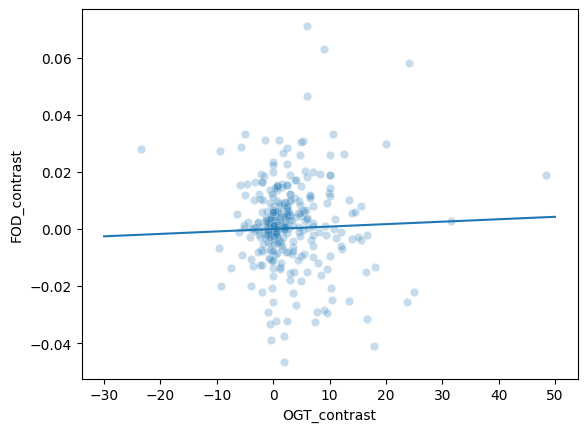

In [442]:
predictions = linear_model.predict([-30, 50])
sns.scatterplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast', alpha=0.25)
sns.lineplot(x=[-30, 50], y=predictions)

In [439]:
polynomial_model = OLS(y, X**2).fit()
print(polynomial_model.summary())

                                 OLS Regression Results                                
Dep. Variable:           FOD_contrast   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              2.139
Date:                Mon, 27 Nov 2023   Prob (F-statistic):                       0.145
Time:                        18:14:02   Log-Likelihood:                          857.60
No. Observations:                 309   AIC:                                     -1713.
Df Residuals:                     308   BIC:                                     -1709.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

<Axes: xlabel='OGT_contrast', ylabel='FOD_contrast'>

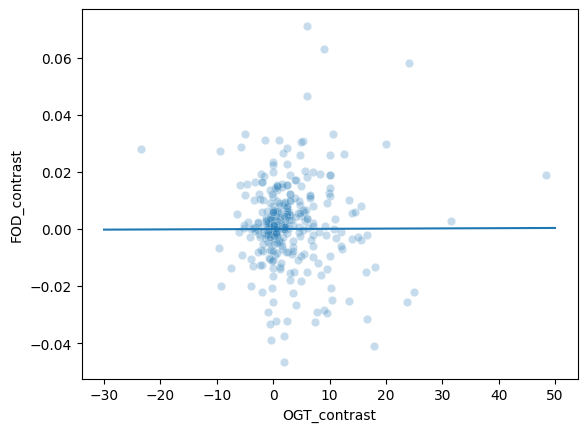

In [443]:
predictions = polynomial_model.predict([-30, 50])
sns.scatterplot(data=OGTvsFOD, x='OGT_contrast', y='FOD_contrast', alpha=0.25)
sns.lineplot(x=[-30, 50], y=predictions)

## NEXT